In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import torch 
from torch.optim import Adam 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences 
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer
import os
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import Adam 
from seqeval.metrics import f1_score

In [7]:
df = pd.read_csv('sentiment_classification.csv')
df['Event Text'].iloc[405]

'2019 / 11 / 22 ニュース リリース 日本 サード ・ パーティ の 「 ThirdAI コンタクトセンターソリューション 」 と 飛躍 的 に 進化 し た 音声 認識 により 、 さらなる オペレーター 支援 の 充実 株式会社 アドバンスト・メディア （ 本社 ： 東京 都 豊島 区 、 代表 取締役 会長 兼 社長 ： 鈴木 清幸 、 以下 ： アドバンスト・メディア ） は AI 音声 認識 「 A miVoiceCommunicationSuite （ アミボイスコミュニケーションスイート ） 」 と 、 日本 サード ・ パーティ 株式会社 （ 本社 ： 東京 都 品川 区 、 代表 取締役 社長 ： 森 豊 、 以下 ： JTP ） の 「 ThirdAI コンタクトセンターソリューション 」 を 連携 し 提供 開始 し た 事 を 、 2019 年 11 月 22 日 に 発表 し まし た 。 JTP の 「 ThirdAI コンタクトセンターソリューション 」 は 、 AI 機能 を 活用 し て コンタクト センター において 顧客 満足 度 の 向上 や 従業 員 満足 度 の 向上 に対する 課題 を 解決 する ソリューション です 。 24 時間 の 顧客 対応 を 実現 する AI チャットボット を はじめ 、 IBM の AI 文章 検索 エンジン 「 IBMWatson ® Discovery 」 を 活用 し 大量 の 情報 から お客様 の 意図 に 沿う 関連 情報 を 「 FAQ 」 「 ドキュメント 」 「 コール スクリプト 」 「 過去 の 応対 履歴 」 等 から 検索 し て 提示 する 事 により オペレーター の 顧客 対応 業務 を 支援 する 仕組み を 提供 し て おり ます 。 今回 、 JTP の 「 ThirdAI コンタクトセンターソリューション 」 は 、 飛躍 的 な 進化 を 続ける AI 音声 認識 「 A miVoiceCommunicationSuite 」 を 連携 し て オペレーター に対して 適切 な 意思 決定 を 支援 する 仕組み を 強化 し ます 。 これ により オペレーター の 回答 品質 を 均一 化 し て 、 お客様 の 満足 度 を

In [38]:
df['Label'] = df['Label'].replace({-1:0})

In [122]:
df['Both'] = df.apply(lambda row: row['Title'] + ' ' + row['Event Text'], axis=1)

In [123]:
PRE_TRAINED_MODEL_NAME = 'bert-base-japanese'
MAX_LEN = 250
tokenizer = BertJapaneseTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
sentences = list(df['Both'])
tokenized_texts = [sent.split(" ") for sent in sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = 'long',
                              truncating = 'post', padding = 'post')

In [124]:
lab2idx = {0:0, 1:1}
labels = list(df['Label'])
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)
labelidx = [lab2idx[label] for label in labels]

In [125]:
batch_size = 32
tr_inputs, val_inputs, tr_labs, val_labs = train_test_split(input_ids, labels, random_state = 3, test_size = 0.3)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state = 3, test_size = 0.3)
tr_inputs, val_inputs = torch.tensor(tr_inputs), torch.tensor(val_inputs)
tr_labs, val_labs = torch.tensor(tr_labs), torch.tensor(val_labs)
tr_masks, val_masks = torch.tensor(tr_masks), torch.tensor(val_masks)
train_data = TensorDataset(tr_inputs, tr_masks, tr_labs)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

valid_data = TensorDataset(val_inputs, val_masks, val_labs)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler = valid_sampler, batch_size = batch_size)

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    n_gpu = torch.cuda.device_count()
    print("Device Name: {}".format(torch.cuda.get_device_name(0)))
else:
    print("Using CPU")

Using CPU


In [127]:
model = BertForSequenceClassification.from_pretrained('bert-base-japanese')
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params' : [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate' : 0.01},
        {'params' : [p for n, p in param_optimizer if any(ned in n for ned in no_decay)],
         'weight_decay_rate' : 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{'params' : [p for n, p in param_optimizer]}]

In [128]:
lr=3e-5
optimizer = Adam(optimizer_grouped_parameters, lr=lr)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps = config.num_warmup_steps, t_total = config.num_total_steps)

In [129]:
epoch = 0
def flat_accuracy(preds, labels):
    """Calculate accuracy of prediction vs true labels
    :param preds: predicted labels
    :param labels: true labels
    :return: % accuracy in float
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    # print(pred_flat, labels_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [131]:
max_grad_norm = 1
dfF1 = pd.DataFrame(columns = ['Train_Loss', 'Validation_Loss', 'Validation_Accuracy', 'F1-Score'])
for i in range(5):
    epoch += 1
    # Train loop
    print('epoch {}'.format(str(epoch)))
    model.train()
    train_loss = 0
    nb_train_examples, nb_train_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        print('backward pass')
        # Add batch to gpu
        if device.type == 'cuda':
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from dataloader
        b_input_ids, b_input_masks, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids = None, attention_mask = b_input_masks, labels = b_labels)
        # backward pass
        loss[0].backward()
        # track train loss
        train_loss += loss[0].item()
        nb_train_examples += b_input_ids.size(0)
        nb_train_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters = model.parameters(), max_norm = max_grad_norm)
        # update parameters - reference (https://pypi.org/project/pytorch-transformers/)
        optimizer.step()
        optimizer.zero_grad() # Clear out the gradients (by deault they accumulate)

    print("Train loss: {}".format(train_loss / nb_train_steps))

    # Validation step
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels, test_input_ids = [], [], []
    for batch in valid_dataloader:
        # add batch to gpu
        if device.type == 'cuda':
            batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from dataloader
        b_input_ids, b_input_masks, b_labels = batch

        # Forward pass, calculate eval_loss and logit predictions
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_masks, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_masks)

        # Move lisits and labels to CPU
        logits = logits[0].detach().cpu().numpy() if device.type == 'cuda' else logits[0].numpy()
        label_ids = b_labels.to('cpu').numpy() if device.type == 'cuda' else b_labels.numpy()
        input_ids = b_input_ids.detach().cpu().numpy() if device.type == 'cuda' else b_input_ids.detach().numpy()

        # Records results
        predictions.append(np.argmax(logits, axis = 1))
        true_labels.append(label_ids.flatten())
        for sent in list(input_ids):
            test_input_ids.append(sent)

        temp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_loss += tmp_eval_loss[0].mean().item()
        eval_accuracy += temp_eval_accuracy

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))
    pred_tags = [str(p_i) for p in predictions for p_i in p]
    valid_tags = [str(l_i) for l in true_labels for l_i in l]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

    dftemp = pd.DataFrame({'Train_Loss' : [train_loss / nb_train_steps],
                           'Validation_Loss' : [eval_loss],
                           'Validation_Accuracy' : [eval_accuracy / nb_eval_steps],
                           'F1-Score' : [f1_score(pred_tags, valid_tags)]})
    dfF1 = pd.concat([dfF1, dftemp], axis = 0)
dfF1 = dfF1.reset_index(drop = True)

epoch 6
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
Train loss: 0.03799116736362604
Validation loss: 0.8039690732955933
Validation Accuracy: 0.8164772727272727
F1-Score: 0.2765957446808511
epoch 7
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
Train loss: 0.004302570797418329
Validation loss: 0.8764211297035217
Validation Accuracy: 0.8227272727272726
F1-Score: 0.22222222222222224
epoch 8
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
backward pass
Train loss: 0.001129638832274147
Validation loss: 0.9908849835395813
Validation Accuracy: 0.8164772727272727
F1-Score: 0.13157894736842107
epoch 9
backward pass


KeyboardInterrupt: 

In [88]:
pred_tags = [[str(p_i) for p in predictions for p_i in p]]
valid_tags = [[str(l_i) for l in true_labels for l_i in l]]
# print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
f1_score(pred_tags, valid_tags)

0

In [99]:
np.mean(np.array([int(x) for x in valid_tags]))

0.18

In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-japanese'
tokenizer = BertJapaneseTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
sample_txt = df['Event Text'].iloc[0]
tokens = sample_txt.split()
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids

[180,
 1,
 1275,
 1,
 2557,
 1,
 391,
 409,
 10444,
 280,
 6,
 542,
 2898,
 2138,
 13326,
 1,
 4703,
 9753,
 1,
 1,
 9,
 6,
 994,
 1926,
 1238,
 459,
 14,
 2969,
 34,
 97,
 76,
 198,
 36,
 91,
 17475,
 4843,
 38,
 320,
 36,
 994,
 1926,
 2164,
 577,
 1,
 17475,
 1189,
 35,
 42,
 1189,
 459,
 5274,
 577,
 1,
 38,
 11,
 9846,
 10133,
 1275,
 1004,
 1240,
 15,
 3913,
 10,
 8,
 12703,
 9,
 14230,
 11,
 4596,
 15,
 6,
 1926,
 1294,
 11,
 16750,
 26,
 796,
 45,
 12,
 6,
 221,
 3614,
 745,
 5,
 2519,
 11,
 3396,
 16,
 21,
 2610,
 8,
 108,
 1240,
 12,
 9,
 6,
 14040,
 4359,
 587,
 6,
 1,
 1189,
 13,
 14040,
 774,
 104,
 5,
 5123,
 14,
 12003,
 6164,
 11,
 1607,
 3659,
 34,
 14040,
 8863,
 36,
 1,
 38,
 530,
 7894,
 5,
 15131,
 5,
 9084,
 11,
 2677,
 1420,
 1,
 3913,
 10,
 8,
 5818,
 28,
 14040,
 4359,
 5,
 6164,
 3659,
 7,
 9084,
 6,
 4359,
 5,
 1764,
 7,
 9475,
 15,
 16,
 4481,
 2610,
 8,
 3073,
 11,
 28294,
 745,
 3251,
 5,
 1,
 5,
 82,
 6,
 6741,
 64,
 5,
 1,
 13,
 139,
 124,
 18,
 6,
 1747

In [25]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=2000,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'S',
 'ラク',
 '##スル',
 '株式会社',
 '(',
 '本社',
 ':',
 '東京',
 '都',
 '品川',
 '区',
 '、',
 '代表',
 '取締役',
 '社長',
 'CEO',
 ':',
 '松本',
 '恭',
 '[UNK]',
 ')',
 'は',
 '、',
 '経済',
 '産業',
 '省',
 '等',
 'が',
 '主催',
 'する',
 '第',
 '5',
 '回',
 '「',
 '日本',
 'ベンチャー',
 '大賞',
 '」',
 'において',
 '「',
 '経済',
 '産業',
 '大臣',
 '賞',
 '(',
 'ベンチャー',
 '企業',
 '・',
 '大',
 '企業',
 '等',
 '連携',
 '賞',
 ')',
 '」',
 'を',
 'ヤマト',
 'ホールディングス',
 '株式会社',
 'と共に',
 '受賞',
 'し',
 'まし',
 'た',
 '。',
 '当社',
 'は',
 'テクノロジー',
 'を',
 '活用',
 'し',
 '、',
 '産業',
 '構造',
 'を',
 '変革',
 'さ',
 'せる',
 'こと',
 'で',
 '、',
 'より',
 '良い',
 '社会',
 'の',
 '実現',
 'を',
 '目指し',
 'て',
 'い',
 'ます',
 '。',
 '本',
 '受賞',
 'で',
 'は',
 '、',
 '物流',
 '業界',
 'における',
 '、',
 '荷',
 '##主',
 '企業',
 'と',
 '物流',
 '事業',
 '者',
 'の',
 '双方',
 'が',
 '抱える',
 '課題',
 'を',
 '同時に',
 '解決',
 'する',
 '物流',
 'プラットフォーム',
 '「',
 'ハ',
 '##コ',
 '##ベル',
 '##コネ',
 '##クト',
 '」',
 '開発',
 'にあたって',
 'の',
 '両社',
 'の',
 '取り組み',
 'を',
 '高く',
 '評価',
 'いただ',
 '##き',
 'まし',
 'た',
 '。',
 '今後',
 'も',
 '物流

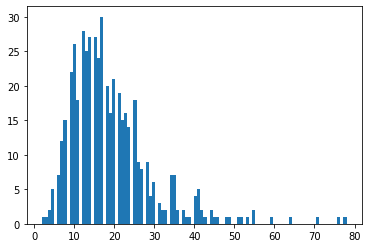

In [100]:
plt.hist(df['Title'].apply(lambda x: len(x.split())), bins=100)
plt.show()

In [23]:
MAX_LEN = 2000

1953.784

In [29]:
df_train, df_val = train_test_split(
  df,
  test_size=0.25,
  random_state=42
)

In [35]:
data = next(iter(train_data_loader))
dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6c1e857050>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


NameError: name 'dict_keys' is not defined